In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# installing detectron2 in google Colab
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [2]:
# importing required libraries
import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# importing some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# importing some detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
# setting up COCO instances for the train and validation data
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, '/content/train/labels_train.json', '/content/train')
register_coco_instances("my_dataset_val", {}, '/content/val/labels_val.json', '/content/val')

In [4]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[01/17 14:57:49 d2.data.datasets.coco]: Loaded 35 images in COCO format from /content/train/labels_train.json


In [5]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[01/17 14:57:49 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/val/labels_val.json


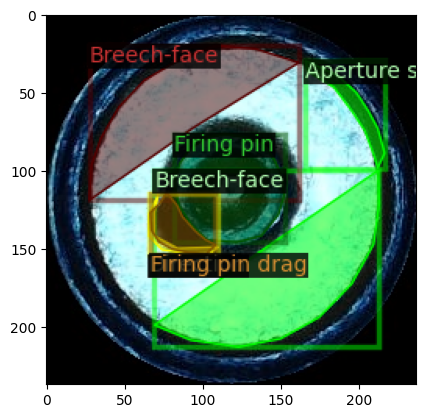

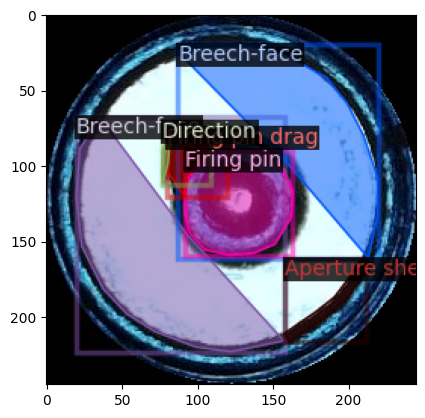

In [6]:
# visualizing some random cartridge case images with custom annotations
from matplotlib import pyplot as plt
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [7]:
# setting up the model for instance segmentation
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val")
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025 #learning rate
cfg.SOLVER.MAX_ITER = 1200
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # batch size
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 # number of classes


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

[01/17 14:58:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 157MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [8]:
# training the model on train data
trainer.train()

[01/17 14:59:20 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/17 14:59:32 d2.utils.events]:  eta: 0:07:40  iter: 19  total_loss: 3.786  loss_cls: 1.801  loss_box_reg: 0.9518  loss_mask: 0.691  loss_rpn_cls: 0.278  loss_rpn_loc: 0.06258    time: 0.3913  last_time: 0.3598  data_time: 0.0307  last_data_time: 0.0068   lr: 4.9953e-06  max_mem: 1775M
[01/17 14:59:42 d2.utils.events]:  eta: 0:07:16  iter: 39  total_loss: 3.627  loss_cls: 1.626  loss_box_reg: 0.9545  loss_mask: 0.6892  loss_rpn_cls: 0.2996  loss_rpn_loc: 0.06483    time: 0.3869  last_time: 0.3738  data_time: 0.0147  last_data_time: 0.0064   lr: 9.9902e-06  max_mem: 1775M
[01/17 14:59:50 d2.utils.events]:  eta: 0:07:08  iter: 59  total_loss: 3.244  loss_cls: 1.329  loss_box_reg: 0.9562  loss_mask: 0.6846  loss_rpn_cls: 0.2001  loss_rpn_loc: 0.05858    time: 0.3856  last_time: 0.3248  data_time: 0.0088  last_data_time: 0.0068   lr: 1.4985e-05  max_mem: 1776M
[01/17 14:59:58 d2.utils.events]:  eta: 0:07:04  iter: 79  total_loss: 2.857  loss_cls: 1.022  loss_box_reg: 0.9336  loss_mask: 0

KeyError: "Dataset 'm' is not registered! Available datasets are: coco_2014_train, coco_2014_val, coco_2014_minival, coco_2014_valminusminival, coco_2017_train, coco_2017_val, coco_2017_test, coco_2017_test-dev, coco_2017_val_100, keypoints_coco_2014_train, keypoints_coco_2014_val, keypoints_coco_2014_minival, keypoints_coco_2014_valminusminival, keypoints_coco_2017_train, keypoints_coco_2017_val, keypoints_coco_2017_val_100, coco_2017_train_panoptic_separated, coco_2017_train_panoptic_stuffonly, coco_2017_train_panoptic, coco_2017_val_panoptic_separated, coco_2017_val_panoptic_stuffonly, coco_2017_val_panoptic, coco_2017_val_100_panoptic_separated, coco_2017_val_100_panoptic_stuffonly, coco_2017_val_100_panoptic, lvis_v1_train, lvis_v1_val, lvis_v1_test_dev, lvis_v1_test_challenge, lvis_v0.5_train, lvis_v0.5_val, lvis_v0.5_val_rand_100, lvis_v0.5_test, lvis_v0.5_train_cocofied, lvis_v0.5_val_cocofied, cityscapes_fine_instance_seg_train, cityscapes_fine_sem_seg_train, cityscapes_fine_instance_seg_val, cityscapes_fine_sem_seg_val, cityscapes_fine_instance_seg_test, cityscapes_fine_sem_seg_test, cityscapes_fine_panoptic_train, cityscapes_fine_panoptic_val, voc_2007_trainval, voc_2007_train, voc_2007_val, voc_2007_test, voc_2012_trainval, voc_2012_train, voc_2012_val, ade20k_sem_seg_train, ade20k_sem_seg_val, my_dataset_train, my_dataset_val"

In [9]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/content/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [10]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
predictor = DefaultPredictor(cfg)

[01/17 15:08:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/model_final.pth ...


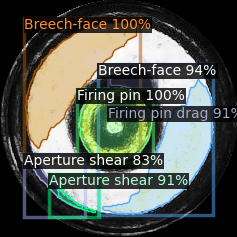

In [11]:
from detectron2.utils.visualizer import ColorMode
# testing model on validation data
for d in random.sample(val_dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

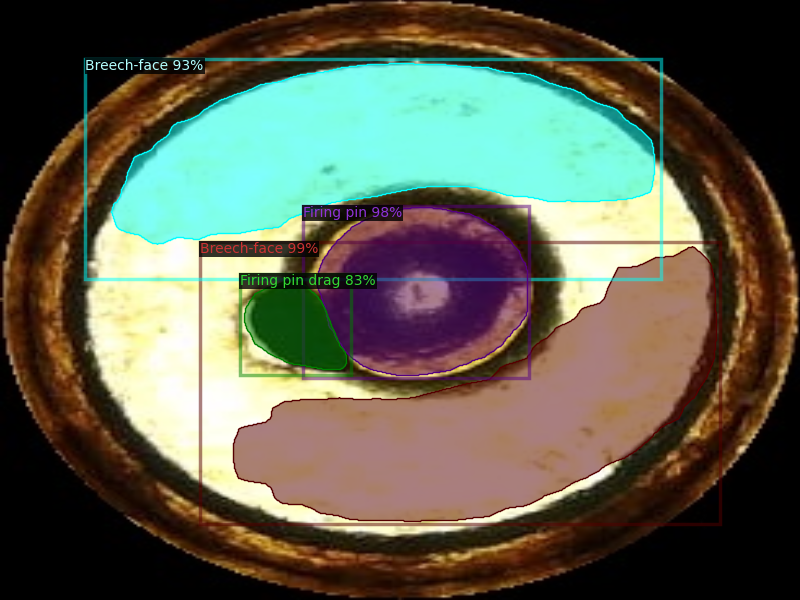

In [12]:
# masking a new cartridge case image
new_im = cv2.imread("/content/9mm cartridge case.jpg")
height, width = 600, 800
new_im = cv2.resize(new_im, (width, height))
outputs  = predictor(new_im)

v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])